In [30]:
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from math import inf
import numpy as np
from matplotlib import pyplot as plt
import math
import sys

def my_ISOMAP(X, n_components, n_neighbors=5, standardize=False):
    """
    Compute the Isomap embedding of dataset X

    Parameters:
    -----------
    X: dataframe
        dataframe with n observation and p features (nxp)
    n_components: int
        number of principal components we want to project on
    n_neighbors: int, default=5
        number of neighbors to take into account for each point to build the graph of geodesic distance

    Returns:
    --------
    numpy array of shape (n, k)
        Return the projected data (nxk), where k is the number of principal components we have projected on
        The low-dimensional representation of the dataset X

    The algorithm procedes as follows:
        - for each point, select the n_neighbors nearest neighbor(s)
        - compute the graph (geodesic) distance using: graph[i,j] == 1 iff point i is one of the n_neighbors nearest neighbor(s) of point j
        - apply floyd-warshall algorithm to the previous graph
        - apply double centering on the adiaceny matrix of the graph obtained before
        - compute the eigenvalues/eigenvectors decomposition
        - choose the first k eigenvector(s)
    """
    if standardize==True:
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        
    # K nearest neighbors
    #neigh = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(X)

    # Construct neighborhood graph
    graph_ = kneighbors_graph(X, n_neighbors= n_neighbors ).toarray()

    print('before', graph_)

    # apply floyd-warshall
    n_nodes = graph_.shape[0]

    for i in range(n_nodes):
        for j in range(n_nodes):
            if i != j and graph_[i,j]== 0:
                graph_[i,j] = inf # use a large number instead of math.inf for numerical reason

    D = np.copy(graph_)
    for k in range(n_nodes):
        for i in range(n_nodes):
            for j in range(n_nodes):
                if D[i,k] + D[k,j] < D[i,j]:
                    D[i,j] = D[i,k] + D[k,j]

    print('after', D)
    
    """
    for k in range(n_nodes):
        for i in range(n_nodes):
            for j in range(n_nodes):
                if graph[i,j] > graph[i,k] + graph[k,j]:
                    graph[i,j] = graph[i,k] + graph[k,j]
    """

    # apply double centering on graph adiacency matrix
    J = np.eye(n_nodes) - 1/n_nodes * np.dot(np.ones(n_nodes), np.ones(n_nodes).T)

    G = -1/2 * np.dot(J, np.dot(D, J))


    # eigenvector decomposition
    eig_vals, eig_vecs = np.linalg.eigh(G) # use .eigh to have the real-value decomposition. Since 'graph' is not guaranteed to be symmetric, B could be complex.

    ###
    print(G)
    print(np.dot(eig_vecs, np.dot(np.diag(eig_vals), np.linalg.inv(eig_vecs))))
    ###
    
    sorted_indices = np.argsort(eig_vals)[::-1]
    sorted_eigvecs = eig_vecs[:,sorted_indices]

    # select the first k eigenvector(s) and project
    top_k_eigvecs = sorted_eigvecs[:n_components]

    projection_matrix = top_k_eigvecs.T

    return np.dot(G, projection_matrix)

## Spiral

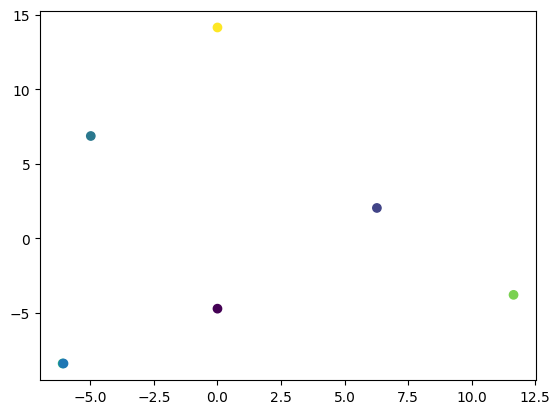

In [31]:
N = 6

phi = np.linspace(1.5*math.pi, 4.5*math.pi, N)

x = phi*np.cos(phi)
y = phi*np.sin(phi)

X = np.array([x,y]).reshape(2,N).T

plt.scatter(x,y, c = phi)

plt.scatter(X[3,0], X[3,1])


In [32]:

neigh = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(X)

graph = neigh.kneighbors_graph(X).toarray()
print(graph)

[[1. 1. 0. 1. 1. 0.]
 [1. 1. 1. 0. 1. 0.]
 [1. 1. 1. 0. 0. 1.]
 [1. 1. 1. 1. 0. 0.]
 [1. 1. 0. 1. 1. 0.]
 [1. 1. 1. 0. 0. 1.]]


before [[0. 1. 1. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1.]
 [1. 1. 0. 1. 0. 1.]
 [1. 1. 1. 0. 1. 0.]
 [1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 1. 0.]]
after [[0. 1. 1. 1. 1. 2.]
 [1. 0. 1. 2. 1. 1.]
 [1. 1. 0. 1. 2. 1.]
 [1. 1. 1. 0. 1. 2.]
 [1. 1. 1. 1. 0. 2.]
 [1. 1. 1. 2. 1. 0.]]
[[-12.5 -13.  -13.  -12.  -12.5 -12. ]
 [-13.  -12.5 -13.  -12.5 -12.5 -11.5]
 [-13.  -13.  -12.5 -12.  -13.  -11.5]
 [-13.  -13.  -13.  -11.5 -12.5 -12. ]
 [-13.  -13.  -13.  -12.  -12.  -12. ]
 [-13.  -13.  -13.  -12.5 -12.5 -11. ]]
[[-12.5 -13.  -13.  -13.  -13.  -13. ]
 [-13.  -12.5 -13.  -13.  -13.  -13. ]
 [-13.  -13.  -12.5 -13.  -13.  -13. ]
 [-13.  -13.  -13.  -11.5 -12.  -12.5]
 [-13.  -13.  -13.  -12.  -12.  -12.5]
 [-13.  -13.  -13.  -12.5 -12.5 -11. ]]


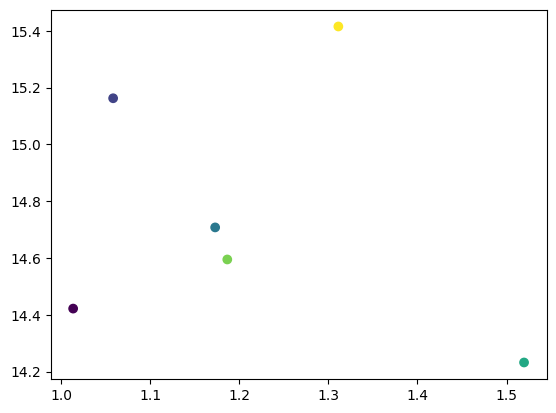

In [33]:
Y = my_ISOMAP(X, n_components=2, n_neighbors=4)

plt.scatter(Y[:,0], Y[:,1], c= phi) # if n_components = 2
#plt.scatter(Y[:,0], np.zeros(X.shape[0]), c = phi)

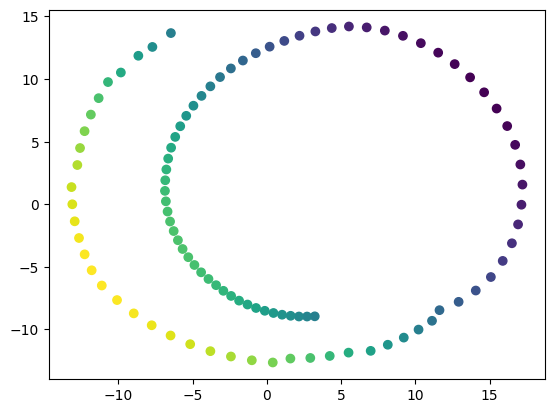

In [127]:
from sklearn.manifold import Isomap
embedding = Isomap( n_components= 2, radius=None, n_neighbors= 12) 
X_new = embedding.fit_transform(X)

plt.scatter(X_new[:,0], X_new[:,1], c=X[:,0]) # if n_components = 2
#plt.scatter(X_new[:,0], np.zeros(X.shape[0]), c=X[:,0])

## Swiss-roll

In [97]:
def swiss_roll(n): #from lab 1
    """
    Parameters:
    n: int
        Number of points to generate
    """
    np.random.seed(1234)
    data = np.zeros((n,3))
    phi = np.random.uniform(low=1.5*np.pi, high=4.5*np.pi, size=n)
    psi = np.random.uniform(0,10,n)
            
    data[:,0]=phi*np.cos(phi) #x coordinte
    data[:,1]=phi*np.sin(phi) #y coordinate
    data[:,2]=psi #z coordinate
    return data

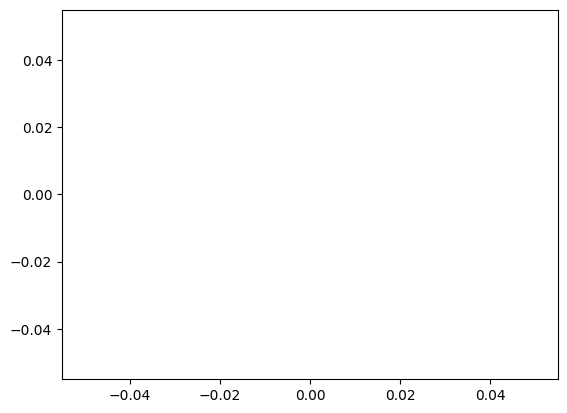

In [111]:
X = swiss_roll(100)
Y = my_ISOMAP(X,2)
plt.scatter(Y[:,0], Y[:,1], c=X[:,0])

Radius

In [81]:
print('min:', X[:,0].min())
print('max:', X[:,0].max())
print('mean:', X[:,0].mean())

print('min:', X[:,1].min())
print('max:', X[:,1].max())
print('mean:', X[:,1].mean())

print('min:', X[:,2].min())
print('max:', X[:,2].max())
print('mean:', X[:,2].mean())

min: -9.449845093933869
max: 12.54143032819567
mean: 0.987188224897488
min: -11.039825572591017
max: 14.023392636540786
mean: -0.5765579367948889
min: 0.09348574500244511
max: 9.946538286442944
mean: 5.367222300605371


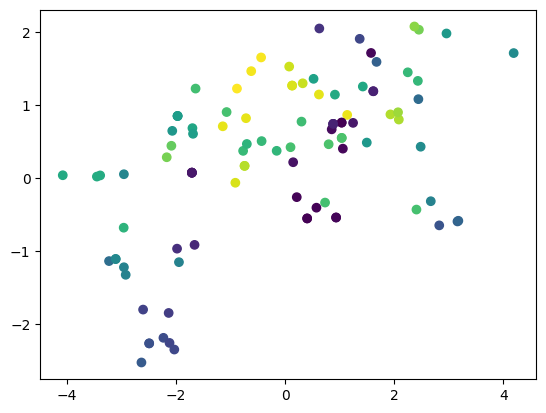

In [112]:
X = swiss_roll(100)
Y = my_ISOMAP(X, k=2, radius=10.0, method='balls')
plt.scatter(Y[:,0], Y[:,1], c=X[:,0])

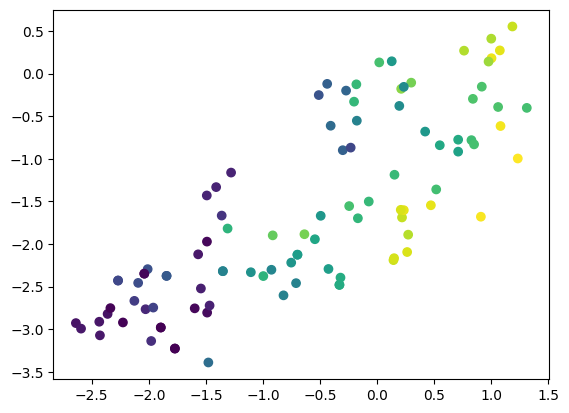

In [113]:
X = swiss_roll(100)
Y = my_ISOMAP(X, k=2, radius=15.0, method='balls')
plt.scatter(Y[:,0], Y[:,1], c=X[:,0])

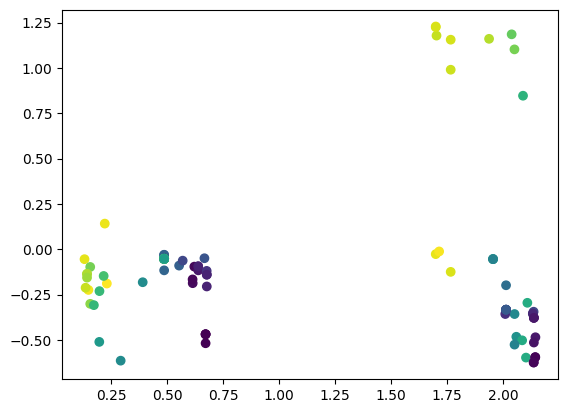

In [114]:
X = swiss_roll(100)
Y = my_ISOMAP(X, k=2, radius=20.0, method='balls')
plt.scatter(Y[:,0], Y[:,1], c=X[:,0])

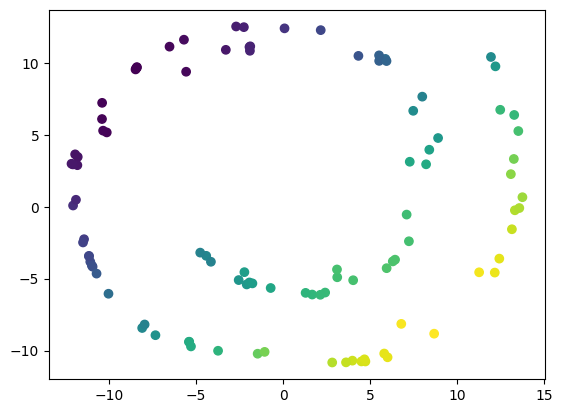

In [115]:
from sklearn.manifold import Isomap
embedding = Isomap( n_components= 2, radius=None, n_neighbors= 35, path_method= 'FW') 
X_new = embedding.fit_transform(X)

plt.scatter(X_new[:,0], X_new[:,1], c=X[:,0])

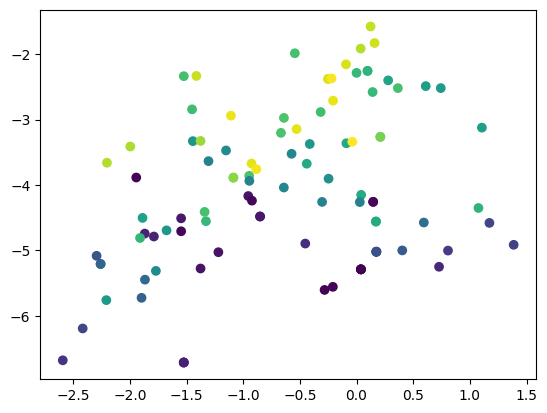

In [116]:
X = swiss_roll(100)
Y = my_ISOMAP(X, k=2, n_neighbors=35, method='kNN')
plt.scatter(Y[:,0], Y[:,1], c=X[:,0])

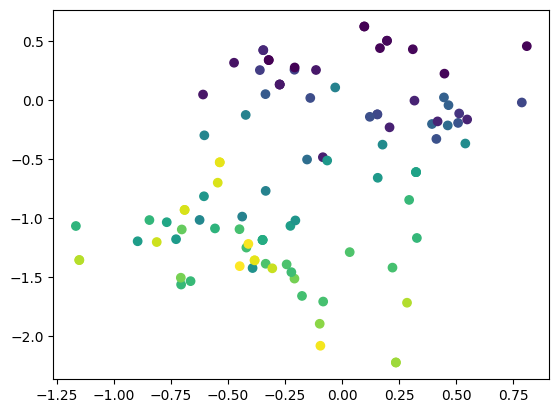

In [117]:
X = swiss_roll(100)
Y = my_ISOMAP(X, k=2, n_neighbors=60, method='kNN')
plt.scatter(Y[:,0], Y[:,1], c=X[:,0])

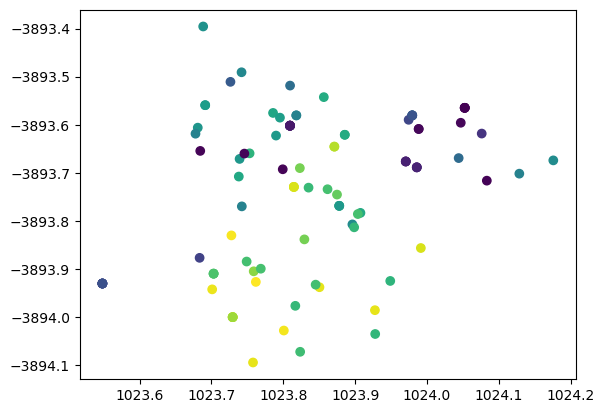

In [61]:
X = swiss_roll(100)
Y = my_ISOMAP(X, k=2, n_neighbors=80, method='kNN')
plt.scatter(Y[:,0], Y[:,1], c=X[:,0])

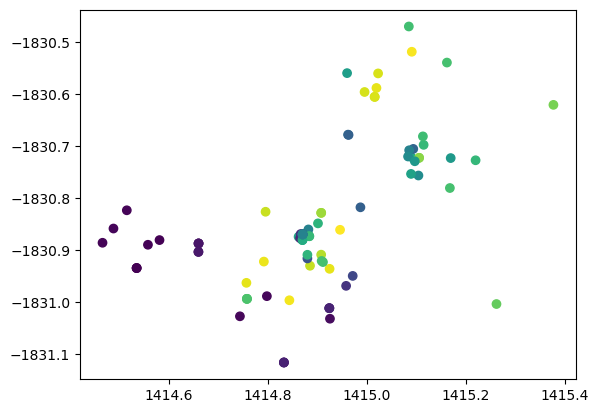

In [82]:
X = swiss_roll(100)
Y = my_ISOMAP(X, k=2, n_neighbors=90, method='kNN')
plt.scatter(Y[:,0], Y[:,1], c=X[:,0])